In [1]:
import math 
import matplotlib.pyplot as plt
import numpy as np

# Graph Representor

In [2]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="png", graph_attr={"rankdir":"LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._operation:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._operation, label=n._operation)
            # and connect this node to it
            dot.edge(uid + n._operation, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

    return dot

# Value Class

In [3]:
class Value:

    def __init__(self, data, _children = (), _operation = "", label = ""):
        self.data = data
        self._prev = set(_children)
        self._operation = _operation
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None

    def __repr__(self):
        result = f"Value(data = {self.data})"
        return result

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        addition = self.data + other.data
        prev = (self, other)
        operation = " + "
        
        result = Value(addition, prev, operation)

        def _backward():
            self.grad += 1.0 * result.grad
            other.grad += 1.0 * result.grad

        result._backward = _backward
        
        return result

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        multiplication = self.data * other.data
        prev = (self, other)
        operation = " x "
        
        result = Value(multiplication, prev, operation)

        def _backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad

        result._backward = _backward
        
        return result

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return self * -1.0

    def __sub__(self, other):
        return self + (-other)
        
    def __truediv__(self, other):
        power = -1
        return self * other ** power
    
    def __rtruediv__(self, other):
        return Value(other).__truediv__(self)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power must be a number"
        power = math.pow(self.data, other)
        prev = (self, )
        operation = " ^ "
        result = Value(data = power, _children = prev, _operation = operation)

        def _backward():
            self.grad = (other * self.data ** (other - 1)) * result.grad

        result._backward = _backward

        return result

    def exp(self):
        exponential = math.exp(self.data)
        prev = (self, )
        operation = "e ^ n"
        result = Value(data = exponential, _children = prev, _operation = operation)

        def _backward():
            self.grad += result.data * result.grad

        result._backward = _backward

        return result

    def tanh(self):
        x = self.data
        prev = (self, )
        operation = "tanh(x)"
        tan_h = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        result = Value(data = tan_h, _children = prev, _operation = operation)

        def _backward():
            self.grad += (1 - tan_h * tan_h) * result.grad
    
        result._backward = _backward

        return result
        

    def backward(self):

        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
        
            for child in v._prev:
                build_topo(child)
        
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

# Testing

Let's calculate tanh(n) function with its own formula. The formula is this 

tanh(n) = (e^(2n) - 1) / (e^(2n) + 1)

In [4]:
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")

w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

b = Value(6.881373587019543, label = "bias")

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

n = x1w1 + x2w2 + b; n.label = "n"

e = (2 * n).exp()

o = (e - 1) / (e + 1)

o.label = "o"
o.backward()

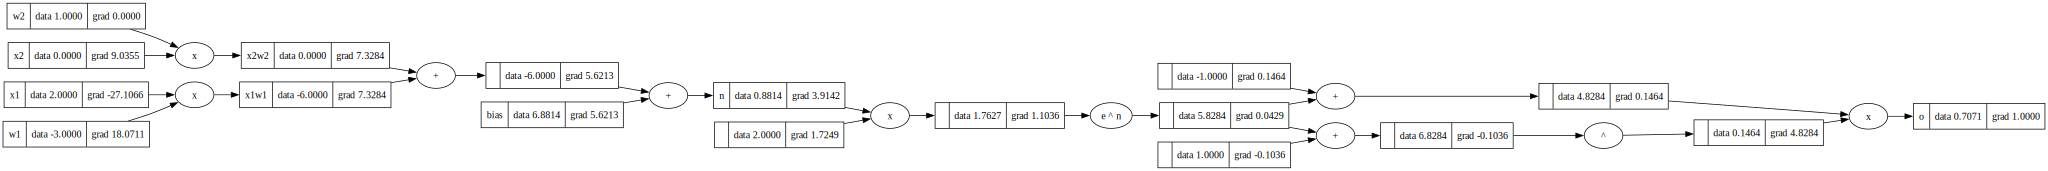

In [5]:
draw_dot(o)

In [6]:
type(o)

__main__.Value

In [7]:
o

Value(data = 0.7071067811865477)

In [9]:
a = Value(2.0, label = "a")
b = Value(4.0, label = "b")

b / 2

Value(data = 2.0)